In [ ]:
# dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import re

import pandas as pd
import polars as pl
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from datetime import timedelta
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.random.seed(42)

## Utils

### parser.py

In [ ]:
from pathlib import Path
from logparser.Drain import LogParser

LOG_FORMAT = '<Label> <Timestamp> <Date> <Node> <Time> <NodeRepeat> <Type> <Component> <Level> <Content>'
SIMILARITY_THRESHOLD = 0.5
TREE_DEPTH = 4

REGEX_PATTERNS = [
    r'core\.\d+',
    r'(?<=r)\d{1,2}',                        # Register numbers
    r'(0x)?[0-9a-fA-F]{8}',                  # Hex addresses
    r'\d+\.\d+\.\d+\.\d+',                   # IP addresses
    r'\d+',                                  # Integers
    r'[a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+',  # Email-like patterns
    r'/[a-zA-Z0-9_/\-\.]+',                  # File paths
]

def _clean_log_file(input_path, output_path, max_lines=None):
    print(f"Cleaning log file: {input_path}")
    if max_lines:
        print(f"Truncating input to first {max_lines} lines.")

    with open(input_path, 'r', encoding='utf-8', errors='ignore') as infile:
        with open(output_path, 'w', encoding='utf-8') as outfile:
            for i, line in enumerate(infile):
                # Stop if we have reached the limit
                if max_lines is not None and i >= max_lines:
                    break

                cleaned = ''.join(c for c in line if c.isalnum() or c in ' .-_:/<>|[]()=+*\n\t')
                outfile.write(cleaned)

    print(f"Cleaned log saved to: {output_path}")

def _count_lines(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        return sum(1 for _ in f)

def parse_logs(input_dir: str, log_filename: str, output_dir: str, truncate_proportion: float = 1.0) -> None:
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    log_stem = Path(log_filename).stem

    original_file = input_path / log_filename
    temp_cleaned_filename = f"cleaned_{log_stem}"
    temp_cleaned_file = input_path / temp_cleaned_filename

    expected_output = output_path / f"cleaned_{log_stem}_structured.csv"

    if expected_output.exists():
        print(f"Skipping: Output file '{expected_output.name}' already exists.")
        return

    print(f"Processing {log_filename}...")

    output_path.mkdir(parents=True, exist_ok=True)

    try:
        max_lines_to_process = None

        if 0 < truncate_proportion < 1.0:
            total_lines = _count_lines(original_file)
            max_lines_to_process = int(total_lines * truncate_proportion)
            print(f"Processing only: {max_lines_to_process}")

        _clean_log_file(str(original_file), str(temp_cleaned_file), max_lines_to_process)

        parser = LogParser(
            LOG_FORMAT,
            indir=str(input_path),
            outdir=str(output_path),
            depth=TREE_DEPTH,
            st=SIMILARITY_THRESHOLD,
            rex=REGEX_PATTERNS
        )

        parser.parse(temp_cleaned_filename)
        print("Parsing complete. Fles generated in {output_dir}: cleaned_{log_stem}_structured.csv and cleaned_{log_stem}_templates.csv")

    except Exception as e:
        print(f"Error parsing {log_filename}: {e}")
        raise

    finally:
        temp_cleaned_file.unlink(missing_ok=True)
        if not temp_cleaned_file.exists():
             print(f"Cleaned up temporary file: {temp_cleaned_filename}")


In [ ]:
def project_root() -> Path:
    try:
        current = Path(__file__).resolve().parent
    except NameError:
        current = Path.cwd()

    for parent in [current, *current.parents]:
        if (parent / "pyproject.toml").exists():
            return parent

    raise RuntimeError("Project root not found (pyproject.toml missing)")

### paths.py

## Parsing

In [ ]:
truncate_proportion = 0.1 # proportion of the log to truncate for testing

# loads parsed logs if needed
parse_logs(f'{project_root()}/data', 'BGL.log', f'{project_root()}/data/parsed', truncate_proportion)
#TODO: for now lines with no content are skipped. Later define if stays this way

Skipping: Output file 'cleaned_BGL_structured.csv' already exists.


In [ ]:
df = pd.read_csv(f'{project_root()}/data/parsed/cleaned_BGL_structured.csv')
df.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
1,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
2,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
3,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
4,5,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]


In [ ]:
CRITICAL_LEVELS = ["ERROR", "SEVERE", "FATAL"]
df["IsCritical"] = df["Level"].isin(CRITICAL_LEVELS).astype(int)

In [ ]:
df.columns

Index(['LineId', 'Label', 'Timestamp', 'Date', 'Node', 'Time', 'NodeRepeat',
       'Type', 'Component', 'Level', 'Content', 'EventId', 'EventTemplate',
       'ParameterList', 'IsCritical'],
      dtype='object')

## processamento

In [ ]:
df = pd.read_csv(f"{project_root()}/data/parsed/cleaned_BGL_structured.csv")

SEVERITY_LEVELS = [
    "INFO",
    "WARNING",
    "SEVERE",
    "ERROR",
    "FAILURE",
    "FATAL"
]

# df["LevelNum"] = df["Level"].map(LEVEL_MAP)

CRITICAL_LEVELS = ["ERROR", "SEVERE", "FATAL"]
df["Critical"] = df["Level"].isin(CRITICAL_LEVELS).astype(int)

df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")
df = df.sort_values("Timestamp")

In [ ]:
def count_by_severity(df, levels):
    return {lvl: (df["Level"] == lvl).sum() for lvl in levels}

def sampling_features(df, levels, delta, total_duration):
    n_samples = int(total_duration / delta)
    features = {}

    start_time = df.index.min()

    for lvl in levels:
        samples = []
        for i in range(n_samples):
            t0 = start_time + i * delta
            t1 = t0 + delta
            count = (df.loc[t0:t1, "Level"] == lvl).sum()
            samples.append(count)
            features[f"{lvl}Sample{i}"] = count

        features[f"{lvl}SampleMean"] = np.mean(samples)
        features[f"{lvl}SampleVariance"] = np.var(samples)

    return features

def last_fail_interval(df, current_time):
    critical_times = df[df["Level"].isin(["FATAL", "FAILURE"])].index
    if len(critical_times) > 0:
        return (current_time - critical_times.max()).total_seconds()
    else:
        return (current_time - df.index.min()).total_seconds()

def build_windows_bgl(
    df,
    window_size="5min",
    future_horizon="1h",
    observation_multiplier=5,  # kΔ
    delta="10min",
    step="1min"
):
    window_size = pd.Timedelta(window_size)
    future_horizon = pd.Timedelta(future_horizon)
    delta = pd.Timedelta(delta)
    step = pd.Timedelta(step)

    observation_period = observation_multiplier * window_size

    df = df.sort_values("Timestamp").set_index("Timestamp")

    X, y, times = [], [], []

    t = df.index.min() + observation_period
    end = df.index.max()

    while t + future_horizon <= end:
        # Observação passada
        obs_df = df.loc[t - observation_period : t]

        # Janela atual
        window_df = df.loc[t - window_size : t]

        future_df = df.loc[t : t + future_horizon]

        if len(window_df) == 0:
            t += step
            continue

        features = {}

        # Grupo 1 — Janela atual
        curr_counts = count_by_severity(window_df, SEVERITY_LEVELS)
        for lvl in SEVERITY_LEVELS:
            features[f"{lvl}Num"] = curr_counts[lvl]

        # Grupo 2 — Acumulado
        acc_counts = count_by_severity(obs_df, SEVERITY_LEVELS)
        for lvl in SEVERITY_LEVELS:
            features[f"Acm{lvl}Num"] = acc_counts[lvl]

        # Grupo 3 — Distribuição temporal
        sampling_feats = sampling_features(
            obs_df,
            SEVERITY_LEVELS,
            delta,
            observation_period
        )
        features.update(sampling_feats)

        # Grupo 4 — Inter-failure
        features["ItvNum2Fatal"] = last_fail_interval(
            df.loc[:t], t
        )

        y.append(
            (future_df["Level"].isin(["FATAL", "FAILURE"])).sum()
        )
        X.append(list(features.values()))
        times.append(t)

        t += step

    return np.array(X), np.array(y), times, list(features.keys())

In [ ]:
# X, y, times = build_windows_count(df)
X, y, times, feature_names = build_windows_bgl(
    df,
    window_size="5min",
    future_horizon="1h",
    observation_multiplier=5,
    delta="10min",
    step="1min"
)

split_idx = int(0.8 * len(X))

X_train_raw, X_val_raw = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]
times_val = times[split_idx:]

In [ ]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)

y_mean = y_train.mean()
y_std = y_train.std() + 1e-6

y_train_n = (y_train - y_mean) / y_std
y_val_n   = (y_val - y_mean) / y_std

In [ ]:
print(y_train.min(), y_train.max())

0 25158


In [ ]:
print(feature_names)

['INFONum', 'WARNINGNum', 'SEVERENum', 'ERRORNum', 'FAILURENum', 'FATALNum', 'AcmINFONum', 'AcmWARNINGNum', 'AcmSEVERENum', 'AcmERRORNum', 'AcmFAILURENum', 'AcmFATALNum', 'INFOSample0', 'INFOSample1', 'INFOSampleMean', 'INFOSampleVariance', 'WARNINGSample0', 'WARNINGSample1', 'WARNINGSampleMean', 'WARNINGSampleVariance', 'SEVERESample0', 'SEVERESample1', 'SEVERESampleMean', 'SEVERESampleVariance', 'ERRORSample0', 'ERRORSample1', 'ERRORSampleMean', 'ERRORSampleVariance', 'FAILURESample0', 'FAILURESample1', 'FAILURESampleMean', 'FAILURESampleVariance', 'FATALSample0', 'FATALSample1', 'FATALSampleMean', 'FATALSampleVariance', 'ItvNum2Fatal']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float64, device=device)
X_val_t   = torch.tensor(X_val, dtype=torch.float64, device=device)

y_train_t = torch.tensor(y_train_n, dtype=torch.float64, device=device)
y_val_t   = torch.tensor(y_val_n, dtype=torch.float64, device=device)

# GP

In [ ]:
import gpytorch

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=train_x.shape[1],
                lengthscale_constraint=gpytorch.constraints.Interval(0.1, 5.0)
            ),
            outputscale_constraint=gpytorch.constraints.Interval(0.1, 2.0)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# class GPRegressionModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super().__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.LinearMean(
#             input_size=train_x.shape[1]
#         )
#         # self.covar_module = kernel
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel(
#                 ard_num_dims=train_x.shape[1],
#                 lengthscale_constraint=gpytorch.constraints.Interval(0.05, 5.0)
#             )
#         )

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
def train_gp(
    model,
    likelihood,
    train_x,
    train_y,
    val_x,
    val_y,
    lr=0.01,
    max_epochs=200,
    patience=20,
    min_delta=1e-4
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    train_losses, val_losses = [], []
    best_val = float("inf")
    patience_ctr = 0

    for epoch in range(max_epochs):
        model.train()
        likelihood.train()
        optimizer.zero_grad()

        with gpytorch.settings.cholesky_jitter(1e-2):
            output = model(train_x)
            loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred_dist = likelihood(model(val_x))
            val_loss = -pred_dist.log_prob(val_y).mean().item()

        val_losses.append(val_loss)

        if val_loss < best_val - min_delta:
            best_val = val_loss
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                break

    return best_val, train_losses, val_losses

In [ ]:
def objective(trial):
    try:
        lr = trial.suggest_float("lr", 1e-3, 2e-2, log=True)
        noise = trial.suggest_float("noise", 1e-4, 0.2, log=True)
        outputscale = trial.suggest_float("outputscale", 0.1, 2.0)

        likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.GreaterThan(1e-4)
        ).to(device).double()
        likelihood.noise = noise

        model = GPRegressionModel(
            X_train_t, y_train_t, likelihood
        ).to(device).double()

        model.covar_module.outputscale = outputscale

        best_val, _, _ = train_gp(
            model,
            likelihood,
            X_train_t,
            y_train_t,
            X_val_t,
            y_val_t,
            lr=lr
        )

        return best_val

    except gpytorch.utils.errors.NotPSDError:
        return float("inf")

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
print(best_params)

[I 2026-01-07 18:42:24,667] A new study created in memory with name: no-name-3028489c-db2f-4110-bd6e-5c0552c0de46
[I 2026-01-07 18:43:33,946] Trial 0 finished with value: 307348.77162540983 and parameters: {'lr': 0.002341931095017268, 'noise': 0.00047798844809246834, 'outputscale': 0.3609438721514394}. Best is trial 0 with value: 307348.77162540983.
[I 2026-01-07 18:44:25,383] Trial 1 finished with value: 119543.31391115297 and parameters: {'lr': 0.006034465309529474, 'noise': 0.0007499255470036668, 'outputscale': 0.12437836634043316}. Best is trial 1 with value: 119543.31391115297.
[I 2026-01-07 18:44:30,023] Trial 2 finished with value: 8598.600531627704 and parameters: {'lr': 0.007663903863007403, 'noise': 0.030051091129555733, 'outputscale': 1.2040848134323456}. Best is trial 2 with value: 8598.600531627704.
[I 2026-01-07 18:45:00,114] Trial 3 finished with value: 45292.77503998411 and parameters: {'lr': 0.0037315274188291646, 'noise': 0.0044031932953568905, 'outputscale': 1.170837

{'lr': 0.001015536337284233, 'noise': 0.19869073744681337, 'outputscale': 1.881352023524038}


In [ ]:
best = best_params

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-4)
).to(device).double()
likelihood.noise = best["noise"]

model = GPRegressionModel(
    X_train_t, y_train_t, likelihood
).to(device).double()

model.covar_module.outputscale = best["outputscale"]

best_val, train_losses, val_losses = train_gp(
    model,
    likelihood,
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    lr=best["lr"]
)

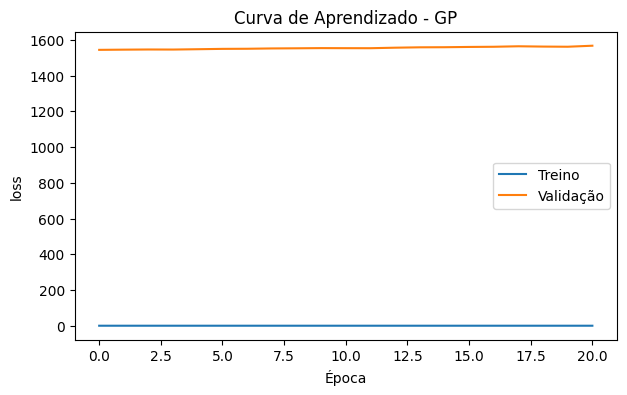

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Treino")
plt.plot(val_losses, label="Validação")
plt.xlabel("Época")
plt.ylabel("loss")
plt.title("Curva de Aprendizado - GP")
plt.legend()
plt.show()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(X_val_t))

mean_pred = pred_dist.mean.cpu().numpy()
std_pred  = pred_dist.stddev.cpu().numpy()

mean_pred = mean_pred * y_std + y_mean
std_pred  = std_pred * y_std

lower = mean_pred - 2 * std_pred
upper = mean_pred + 2 * std_pred

In [ ]:
mean_pred = np.clip(mean_pred, 0, None)

max_std = np.percentile(std_pred, 95)
std_pred = np.minimum(std_pred, max_std)

lower = np.maximum(mean_pred - 2 * std_pred, 0)
upper = mean_pred + 2 * std_pred


In [ ]:
rmse = np.sqrt(np.mean((y_val - mean_pred) ** 2))
coverage = np.mean((y_val >= lower) & (y_val <= upper))

print(f"RMSE: {rmse:.3f}")
print(f"Cobertura 95%: {coverage:.3f}")

RMSE: 7263.213
Cobertura 95%: 0.888


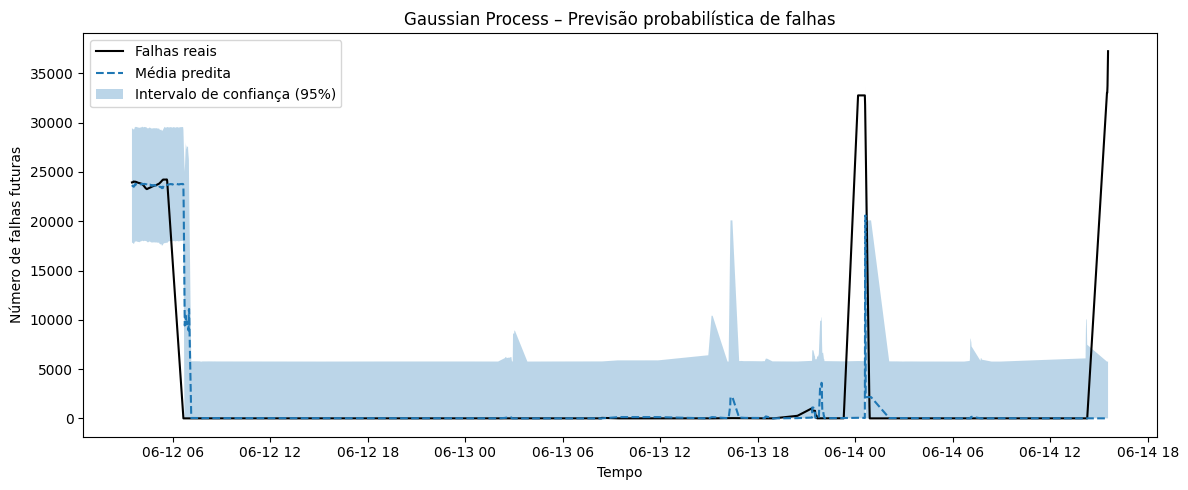

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(times_val, y_val, label="Falhas reais", color="black")

plt.plot(times_val, mean_pred, label="Média predita", linestyle="--")

plt.fill_between(
    times_val,
    lower,
    upper,
    alpha=0.3,
    label="Intervalo de confiança (95%)"
)

plt.legend()
plt.title("Gaussian Process – Previsão probabilística de falhas")
plt.xlabel("Tempo")
plt.ylabel("Número de falhas futuras")
plt.tight_layout()
plt.show()




---



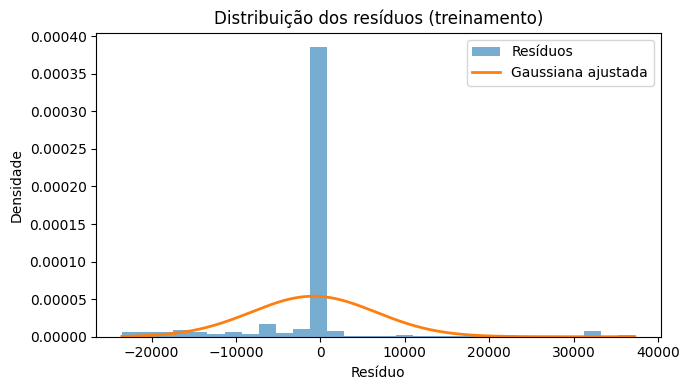

In [ ]:
mu_res = residuals.mean()
sigma_res = residuals.std()

x = np.linspace(
    residuals.min(),
    residuals.max(),
    200
)

plt.figure(figsize=(7, 4))

plt.hist(
    residuals,
    bins=30,
    density=True,
    alpha=0.6,
    label="Resíduos"
)

plt.plot(
    x,
    stats.norm.pdf(x, mu_res, sigma_res),
    linewidth=2,
    label="Gaussiana ajustada"
)

plt.xlabel("Resíduo")
plt.ylabel("Densidade")
plt.title("Distribuição dos resíduos (treinamento)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(5, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q plot dos resíduos")
plt.tight_layout()
plt.show()


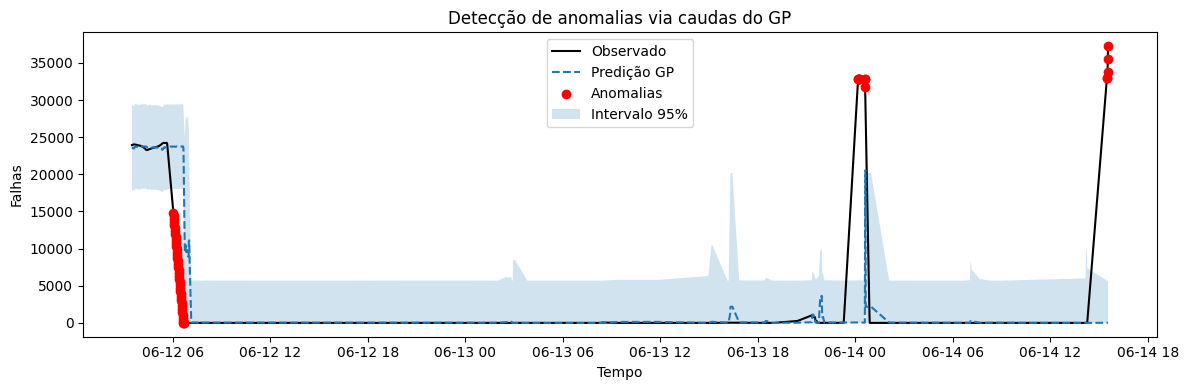

In [ ]:
times_val_np = np.asarray(times_val)
y_val_np     = np.asarray(y_val)


z_scores = (y_val - mean_pred) / std_pred
k = 3.0
anomalies = np.abs(z_scores) > k
plt.figure(figsize=(12, 4))

plt.plot(times_val, y_val, label="Observado", color="black")
plt.plot(times_val, mean_pred, "--", label="Predição GP")

plt.scatter(
    times_val_np[anomalies],
    y_val_np[anomalies],
    color="red",
    label="Anomalias",
    zorder=3
)

plt.fill_between(
    times_val,
    lower,
    upper,
    alpha=0.2,
    label="Intervalo 95%"
)

plt.legend()
plt.xlabel("Tempo")
plt.ylabel("Falhas")
plt.title("Detecção de anomalias via caudas do GP")
plt.tight_layout()
plt.show()


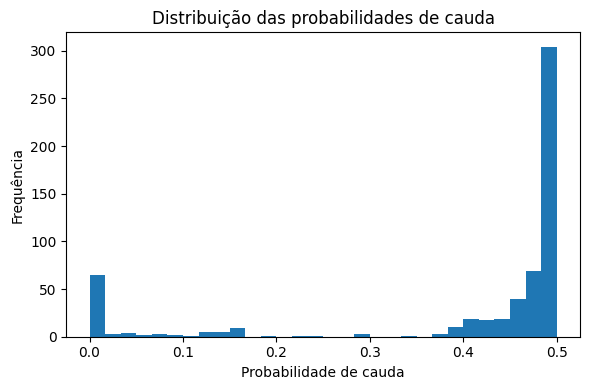

In [ ]:
with torch.no_grad():
    prob = stats.norm.cdf(y_val, loc=mean_pred, scale=std_pred)

tail_prob = np.minimum(prob, 1 - prob)
anomalies_prob = tail_prob < 0.001
plt.figure(figsize=(6, 4))
plt.hist(tail_prob, bins=30)
plt.xlabel("Probabilidade de cauda")
plt.ylabel("Frequência")
plt.title("Distribuição das probabilidades de cauda")
plt.tight_layout()
plt.show()
